# Product Category Prediction
### DALI 2024 Spring Application - Machine Learning Track


The Superstore.csv file is missing 999 entries in each column, incuding the Product Category and Product Sub-Category columns.  As these columns are useful features for predicting the profit of a purchase, approximating values for these missing entries would give us more data to train a machine learning model to predict profit.  This file contains code to train a deep learning based approach to predict product category from product name.  Note that one could easily modify this code to predict product sub-category from product category by changing the classifiaction layer of the model and the code to load the dataset.  I also use shapley values a way of imporving interpretability of the black-box BERT model.

Areas for expansion (I would perform these if I had the compute to do so):
- Hyperparameter tuning
- Testing different model architectures for the decoder
- Testing different pre-trained transformers for the encoder



In [ ]:
!pip install shap

In [2]:
import pandas as pd
import transformers
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torch import nn
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import sys
import shap
import matplotlib.pyplot as plt
import torch.nn.functional as F
import random

## Prepare the Dataset

We first need to prepare the dataset for machine learning.  This involves loading it, generating correct class labels, splitting it into train, validation and test sets, and tokenizing the product names.  

Splitting the dataset into train, validation and test sets is important to prevent data leakage.  The purpose of each set is as follows:

- Train: The data to train the model on, refining it over time.
- Validation: The dataset on which to optimize performance when tuning hyperparameters.
- Test: The dataset to evaluate the model on after training and hyperparameter tuning.  This gives an indication of the model's real-world performace.

If we train on data outside the train dataset, we will artificially inflate our model's performance because the model will have seen the data in that set before.  Similarly, if we optimize our test set performance when tuning hyperparameters, the test set performance will be artifially inflated and we won't have good means of measuring the model's real world performance.  For this project, we use a 70-15-15 train test validation split.


In [ ]:
RANDOM_STATE = 42 # random seed to ensure results are reproducible
BATCH_SIZE = 16 # number of documents in each minibatch for training

In [ ]:
df = pd.read_csv('Superstore.csv') # requires the Superstore.csv to be uploaded if you are running this in colab

The below cell drops all entries with a null category and/or product name.  We are assuming data entries are missing completely at random, so this should not introduce bias into the dataset.

In [ ]:
df.dropna(subset=["Category", "Product Name"], inplace=True)
print("Number of rows: " + str(df.shape[0]))

Number of rows: 8098


In [ ]:
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased') # load the tokenizer

In [ ]:
textLabels = df["Category"]
print(textLabels)

0             Furniture
1             Furniture
2       Office Supplies
3             Furniture
4       Office Supplies
             ...       
9988         Technology
9990          Furniture
9991         Technology
9992    Office Supplies
9993    Office Supplies
Name: Category, Length: 8098, dtype: object


In [ ]:
names = df["Product Name"].tolist()
productLabels=np.unique(df['Category'], return_inverse=True)[1].tolist() # generate numerical labels from product category names
print(np.unique(df['Category'], return_inverse=True))

(array(['Furniture', 'Office Supplies', 'Technology'], dtype=object), array([0, 0, 1, ..., 2, 1, 1]))


In [ ]:
# shuffles the data and splits it into the train, test, and validation sets
train, validAndTest, trainLabels, validAndTestLabels = train_test_split(names, productLabels, test_size=0.3, random_state=RANDOM_STATE)
valid, test, validLabels, testLabels = train_test_split(validAndTest, validAndTestLabels, test_size=0.5, random_state=RANDOM_STATE)

In the below cell, we tokenize the product names.  Tokenization is an important pre-processing step that converts raw text into a format suitable for input into the BERT model.  This involves breaking the text into indivudal units of words and subwords called tokens.  Each token is then mapped to a unique integer ID based on a predefined vocabulary. BERT typically uses a large vocabulary containing tens of thousands of tokens from its training data.  The vocabulary also contains special tokens [CLS] (to denote the beginning of the input sequence), [SEP] (to separate two distinct sentences or segments within a single input sequence), and [PAD]  (to pad input sequences to the fixed length the BERT model expects).

BERT expects all input to have a fixed length, so we pad shorter product names to that length and truncate longer ones.  Importantly, we must keep track of the tokenizer's attention masks when we pad.  Attention masks are binary masks indicating which tokens should be attended to by the model and which ones should be ignored.  Without them, the model will pay attention to meaningless padding tokens and performance will be reduced.



In [ ]:
# tokenize the product names - turns them into a format the BERT model can understand
trainTokenized = tokenizer(train, padding='max_length', max_length = 512, truncation=True, return_tensors='pt', return_attention_mask = True)
validTokenized = tokenizer(valid, padding='max_length', max_length = 512, truncation=True, return_tensors='pt', return_attention_mask = True)
testTokenized = tokenizer(test, padding='max_length', max_length = 512, truncation=True, return_tensors='pt', return_attention_mask = True)

trainTokens = trainTokenized["input_ids"]
trainMask = trainTokenized["attention_mask"]

validTokens = validTokenized["input_ids"]
validMask = validTokenized["attention_mask"]

testTokens = testTokenized["input_ids"]
testMask = testTokenized["attention_mask"]


In [ ]:
print(len(train))
print(len(trainLabels))
print()

print(len(valid))
print(len(validLabels))
print()

print(len(test))
print(len(testLabels))

5668
5668

1215
1215

1215
1215


In [ ]:
# a class to represent the train, validation, and test sets
# the Dataset class handles dividing the data into minibatches and producing the minibatches for us
class productNamesDataset(Dataset):
  def __init__(self, data, labels, mask):
    self.data = data
    self.labels = labels
    self.mask = mask

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    return self.data[idx], self.labels[idx], self.mask[idx]

In [ ]:
# build the dataset objects for train, validation, and test sets
trainData = productNamesDataset(trainTokens, trainLabels, trainMask)
validData = productNamesDataset(validTokens, validLabels, validMask)
testData = productNamesDataset(testTokens, testLabels, testMask)

In [ ]:
# build the dataloader objects for train, validation, and test sets
trainLoader = DataLoader(trainData, batch_size=BATCH_SIZE)
validLoader = DataLoader(validData, batch_size=BATCH_SIZE)
testLoader = DataLoader(testData, batch_size=1)

## Prepare the Model

The below are the hyperparameters I have chosen for this model.  If I had the computational resources, I would tune these hyperparameters.  I would perform a grid search using the skorch package.  A grid search is where several possible values for each hyperparmaeter are specified beforehand, and all possible combinations of values of hyperparameters are tested.  Other methods to tune hyperparameters are Baysean Optimization (which uses statistical inference to iteratively select hyperparameters expected to give the greatest performance improvements) and Random Search (which randomly selects hyperparameter values from pre-defined ranges and tests them).

In [ ]:
DROPOUT = 0.2 # probability of dropping a node in the linear layer after the BERT encoder
ATTN_DROPOUT = 0.2 # probability of dropping a term in the attention equation within the BERT encoder
EPOCHS = 10 # number of times we train the model on the full train set
LEARNING_RATE = 0.001 # scales how much we update our parameters after each minibatch

In [ ]:
# load huggingface pretrained model
dbert = transformers.DistilBertModel.from_pretrained('distilbert-base-uncased', dropout=DROPOUT, attention_dropout=ATTN_DROPOUT)

In [ ]:
# Get cpu or gpu device for training - THIS CODE WORKS BEST ON A GPU
device = "cuda" if torch.cuda.is_available() else "cpu" # need to change options to train on GPU
print(f"Using {device} device")

Using cuda device


The class below defines our model architecture for our classifier.  We can think of this model as having an encoder/decoder architecture - the encoder generates a vector capturing document context from each product name, and the decoder uses that vector to generate its predicted class.  In this case, our encoder is the pre-trained BERT model we use, and our decoder is the two linear layers we place on top of our BERT model.  We use the output of the last layer of the BERT model as our context vector, which is a standard practice for natural language processing.  We perform dropout on the first linear layer after our BERT output, which improves regularization and reduces overfitting.  We use a ReLU activation function between our two linear layers, which is one of the most efficient activation functions available for deep learning.

In [ ]:
class DistilBertClassification(nn.Module):
    def __init__(self):
        super(DistilBertClassification, self).__init__()
        # BERT encoder
        self.dbert = dbert
        # Decoder
        self.dropout = nn.Dropout(p=DROPOUT)
        self.linear1 = nn.Linear(768,64)
        self.ReLu = nn.ReLU()
        self.linear2 = nn.Linear(64,3)

    def forward(self, tokens, mask):
        x = self.dbert(input_ids=tokens, attention_mask=mask)
        x = x["last_hidden_state"][:,0,:]
        x = self.dropout(x) # dropout on BERT output, prevents overfitting
        x = self.linear1(x)
        x = self.ReLu(x)
        logits = self.linear2(x)
        return logits

In [ ]:
# Check the architecture of the model we have created
classifier = DistilBertClassification().to(device)
print(classifier)

DistilBertClassification(
  (dbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.2, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.2, inplace=False)
            (lin1

We set the weights and biases of the pre-trained BERT model we use as our encoder to not be updated during our training.  This avoids catastrphic forgetting - where a pretrained large language model "forgets" the knowledge it learned from its initial training when it is used for supervised transfer learning.  This step will help improve the overall generalizability of our model.

In [ ]:
for param in classifier.dbert.parameters():
    param.requires_grad = False

In [ ]:
# Check the number of total parameters and number of trainable parameters
total_params = sum(p.numel() for p in classifier.parameters())
total_params_trainable = sum(p.numel() for p in classifier.parameters() if p.requires_grad)
print("Number of parameters: ", total_params)
print("Number of trainable parameters: ", total_params_trainable)

Number of parameters:  66412291
Number of trainable parameters:  49411


## Training

We now train the model using the hyperparameters we specified above.  At each epoch, we evaluate the model on the validation set.  We use cross entropy loss as our loss function and Adaptive Moment Estimation as our optimization algorithm to determine how we update our parameters.  Both of these choices are standard for deep learning NLP work.

In [ ]:
criterion = torch.nn.CrossEntropyLoss() # softmax and loss for classification layer
optimizer = torch.optim.Adam(classifier.parameters(), lr = LEARNING_RATE)

In [ ]:
history = {}
history["epoch"]=[]
history["train_loss"]=[]
history["valid_loss"]=[]
history["train_accuracy"]=[]
history["valid_accuracy"]=[]

In [ ]:
# training loop
for e in range(EPOCHS):
  classifier.train() # activated dropout

  train_loss = 0.0
  train_accuracy = []

  # loop over each minibatch
  for description, labels, mask in tqdm(trainLoader):

      # send minibatch to gpu for efficient training
      description = description.to(device)
      labels = labels.to(device)
      mask = mask.to(device)

      # Get prediction & loss
      prediction = classifier(description, mask)
      loss = criterion(prediction, labels)

      train_loss += loss.item()

      # determine the optimal direction to increment parameters
      loss.backward()

      # update parameters
      optimizer.step()

      # zero the gradient so we don't accumulate optimizer steps
      optimizer.zero_grad()

      prediction_index = prediction.argmax(axis=1)
      accuracy = (prediction_index==labels)
      train_accuracy += accuracy

  train_accuracy = (sum(train_accuracy) / len(train_accuracy))

  classifier.eval() # turn off dropout for evaluation
  valid_loss = 0.0
  valid_accuracy = []

  with torch.no_grad(): # turn off gradient calculation so we don't train on the validation set
    for description, labels, mask in validLoader:

      description = description.to(device)
      labels = labels.to(device)
      mask = mask.to(device)

      prediction = classifier(description, mask)
      loss = criterion(prediction, labels)

      valid_loss += loss.item()

      prediction_index = prediction.argmax(axis=1)
      accuracy = (prediction_index==labels)
      valid_accuracy += (accuracy)

  valid_accuracy = (sum(valid_accuracy) / len(valid_accuracy)) # sum sums up the boolean tensors, which themselves have a method to sum up

  # keep a record of our training results
  history["epoch"].append(e+1)
  history["train_loss"].append(train_loss / len(trainLoader))
  history["valid_loss"].append(valid_loss / len(validLoader))
  history["train_accuracy"].append(train_accuracy.cpu())
  history["valid_accuracy"].append(valid_accuracy.cpu())

  # output results
  print(f'Epoch {e+1}')
  print(f'\t\t Training Loss: {train_loss / len(trainLoader) :10.3f} \t\t Validation Loss: {valid_loss / len(validLoader) :10.3f}')
  print(f'\t\t Training Accuracy: {train_accuracy :10.3%} \t\t Validation Accuracy: {valid_accuracy :10.3%}')

100%|██████████| 355/355 [01:34<00:00,  3.76it/s]


Epoch 1
		 Training Loss:      0.465 		 Validation Loss:      0.281
		 Training Accuracy:    81.193% 		 Validation Accuracy:    89.465%


100%|██████████| 355/355 [01:38<00:00,  3.60it/s]


Epoch 2
		 Training Loss:      0.285 		 Validation Loss:      0.249
		 Training Accuracy:    89.450% 		 Validation Accuracy:    89.877%


100%|██████████| 355/355 [01:38<00:00,  3.59it/s]


Epoch 3
		 Training Loss:      0.256 		 Validation Loss:      0.181
		 Training Accuracy:    90.596% 		 Validation Accuracy:    94.321%


100%|██████████| 355/355 [01:39<00:00,  3.58it/s]


Epoch 4
		 Training Loss:      0.245 		 Validation Loss:      0.171
		 Training Accuracy:    90.826% 		 Validation Accuracy:    94.403%


100%|██████████| 355/355 [01:39<00:00,  3.59it/s]


Epoch 5
		 Training Loss:      0.249 		 Validation Loss:      0.149
		 Training Accuracy:    90.438% 		 Validation Accuracy:    95.556%


100%|██████████| 355/355 [01:38<00:00,  3.59it/s]


Epoch 6
		 Training Loss:      0.224 		 Validation Loss:      0.145
		 Training Accuracy:    91.461% 		 Validation Accuracy:    94.897%


100%|██████████| 355/355 [01:38<00:00,  3.60it/s]


Epoch 7
		 Training Loss:      0.219 		 Validation Loss:      0.126
		 Training Accuracy:    91.814% 		 Validation Accuracy:    96.132%


100%|██████████| 355/355 [01:38<00:00,  3.59it/s]


Epoch 8
		 Training Loss:      0.202 		 Validation Loss:      0.136
		 Training Accuracy:    92.414% 		 Validation Accuracy:    95.802%


100%|██████████| 355/355 [01:39<00:00,  3.58it/s]


Epoch 9
		 Training Loss:      0.207 		 Validation Loss:      0.123
		 Training Accuracy:    92.149% 		 Validation Accuracy:    95.885%


100%|██████████| 355/355 [01:38<00:00,  3.62it/s]


Epoch 10
		 Training Loss:      0.198 		 Validation Loss:      0.103
		 Training Accuracy:    92.625% 		 Validation Accuracy:    96.296%


The below graphs plot training and validation accuracy and loss against training epochs.  Notably, the validation loss is lower than the training loss, and the validation accuracy is higher than the training accuracy.  This is concerning because it could mean data leakage has occured - where the model has inadvertantly trained on validation set data.  However, the way we separated our training, validation, and test sets has ensured this did not occur.  

Instead, I predict this discrepency is due to a combination of data mismatch and regularization.  Perhaps the way we randomly split our dataset lead to a less noisy validation set or a validation set with easier examples.  Additionally, the dropout layer we set to improve regularization could be improving our model's generlaizability at the cost of performance on the training set.

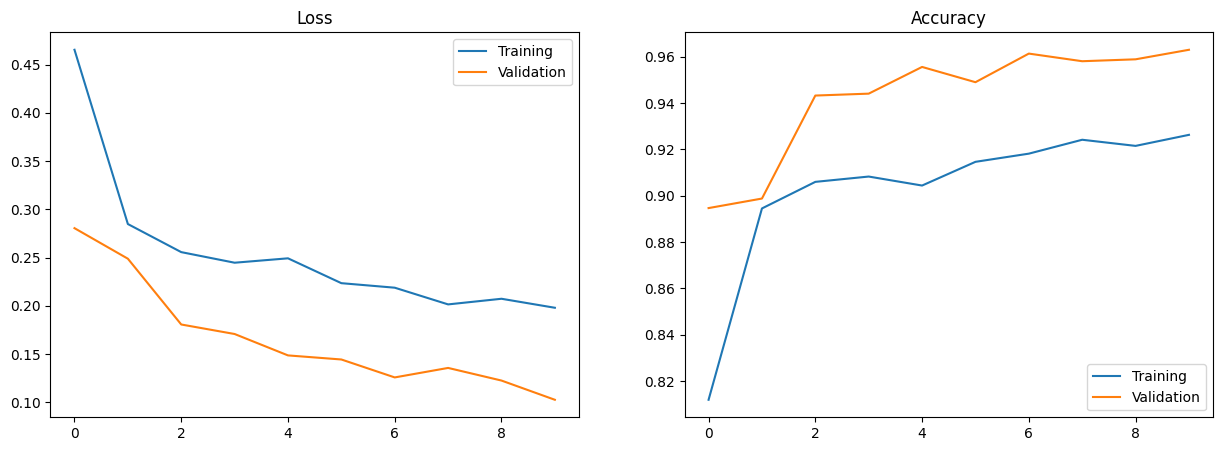

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].set(title='Loss')
ax[0].plot(history['train_loss'], label='Training')
ax[0].plot(history['valid_loss'], label='Validation')
ax[0].legend(loc="upper right")

ax[1].set(title='Accuracy')
ax[1].plot(history['train_accuracy'], label='Training')
ax[1].plot(history['valid_accuracy'], label='Validation')
ax[1].legend(loc="lower right")

## Evaluation on the Test Set

Now that we have trained the model (and optimized the hyperparameters on the validation set) we need to determine how well it would perform in a real-word environment.  This can be done by evaluating its performance on the test set.  By splitting the dataset into train, validation, and test sets, we have ensured the model has not been trained on documents in the test set and we have not "cheated" by tuning our hyperparameters to gain optimal performance on the test set.  Therefore, the model's performance on the test set is a good indication of how it would perform in the real world.\
\
0 is the furniture class\
1 is the office supplies class\
2 is the technology class

In [ ]:
classifier.eval()

groundTruth = np.zeros(len(testLoader)) # holds the labels for the test set
predictions = np.zeros(len(testLoader)) # holds the model's predictions on the test set


i = 0
with torch.no_grad(): # turn off gradient calculation so we don't train on the test set
  for description, label, mask in tqdm(testLoader):
    description = description.to(device)
    label = label.to(device)
    mask = mask.to(device)

    prediction = classifier(description, mask)
    predictedClass = int(prediction.argmax(axis=1).item()) # determine the model's prediction on a test set document
    predictions[i] = predictedClass


    goldClass = int(label.item())
    groundTruth[i] = goldClass

    i+= 1

100%|██████████| 1215/1215 [00:22<00:00, 53.49it/s]


In [ ]:
print(classification_report(groundTruth, predictions)) # print precision, recall, and f1 for each class and overall

              precision    recall  f1-score   support

         0.0       0.97      0.91      0.94       255
         1.0       0.96      0.98      0.97       720
         2.0       0.96      0.96      0.96       240

    accuracy                           0.96      1215
   macro avg       0.97      0.95      0.96      1215
weighted avg       0.96      0.96      0.96      1215



From the classification report, we see this model is performing well on the classification task.  The overall accuracy is well above the accuracy we would obtain by guessing the class randomly.  One thing to note is that these kind of deep learning models typically require more memory and time to perform interence than more lightweight models like logistic regression.  However, this model would only need to perform inference once as part of a data pipeline to fill in the missing cells in the superstore dataset.  This is not a task that requires us to prioritize performance, so the accuracy gained from using this type of model is worth the performance trade-off.

In [ ]:
 print(confusion_matrix(groundTruth, predictions)) # print confusion matrix

[[233  22   0]
 [  5 706   9]
 [  1   9 230]]


## Save the Trained Model

This allows us to use the model we have created for inference without having to train it again.  This would be useful in a data pipeline where we fill in missing values in the superstore dataset before using it to train another model for a different task. For instance, when predicting the profit of a purchase where product category is a useful feature, using this model to fill in the 999 rows missing product category could give us up to an additional 999 rows to train/test on

In [ ]:
# This cell is only necessary if you are running this notebook in Colab
from google.colab import drive
import os

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
path = "/content/gdrive/MyDrive/ColabOutput/checkpoint.pth" # path to save to

torch.save(classifier.state_dict(), path)

## Shapley Values

Shapley values are a game theory concept that can be used to explain the contribution of each feature to a model's prediction for a specific instance.  They are especially useful with BERT models, which are otherwise a black box.  

Shapley values assign a value to each feature based on its marginal contribution to the prediction when added to all possible subsets of features.  This calculation captures interactions between distinct features  A positive Shapley value for a feature indicates that its presence increases the prediction relative to its absence, while a negative value indicates the opposite. The magnitude of the Shapley value represents the importance or influence of the feature on the prediction.  

Shapley values satisfy several "nice" proerties, including efficiency (the sum of Shapley values equals the difference between the model's prediction for the instance and the average prediction), symmetry (interchangeable features receive the same Shapley value), and linearity (the sum of Shapley values equals the total model prediction change when considering all features).  They are also model-agnostic, meaning they can be applied to any machine learning model.  

While calculating all shapley values exactly is computationally infeasible, the shap library allows us to approximate them resonably quickly.  The below plots show the shapley values for an example of each class I found from Amazon (and therefore not in the training set) and an example that doesn't fall into any of the model's categories.  In each plot, the "base value" of a class the shapley value of that class we would predict if we didn't know any of our specific example's features based on the dataset we pass the shap library.  One can observe the shapley values of each token for each example and how they move the overall prediction from its base value.

Enouragingly, the correct class for the first three examples is predicted correctly with a high shapley value.  This gives us confidence that the model is learning correct assosiations between different tokens and their corresponding class.  For the "no class" example, the Shapley values are noticably lower than they are for the first three examples.  This is also encouraging because it means the model isn't assosiating extraneous tokens with any specific class.

### Citations
I learned about shapley values and how to use the library from:
- A Unified Approach to Interpreting Model Predictions by Lundberg et al.
- https://github.com/shap/shap    \
- https://shap.readthedocs.io/en/latest/

In [ ]:
# load the trained model for shap
classifier = DistilBertClassification().to(device)
state_dict = torch.load(path)
classifier.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
# function to predict a specific example - needed to show shap how to use our model
def predict(example):
  tokens = []
  mask = []

  for val in example:
    tokenized = tokenizer.encode_plus(val, padding='max_length', max_length = 512, truncation=True, return_attention_mask=True)
    tokens.append(tokenized["input_ids"])
    mask.append(tokenized["attention_mask"])

  tokens = torch.tensor(tokens).to(device)
  mask = torch.tensor(mask).to(device)

  outputs = classifier(tokens, mask)
  probabilities = F.softmax(outputs, dim=1)

  return probabilities


In [ ]:
# ground truth: furniture
furniture_explainer = shap.Explainer(predict, tokenizer, output_names=['Furniture', 'Office Supplies', 'Technology'])
shap_values = furniture_explainer(["HONBAY Modular Sectional Sleeper Sofa"])
shap.plots.text(shap_values)

In [ ]:
# ground truth: office supplies
office_explainer = shap.Explainer(predict, tokenizer, output_names=['Furniture', 'Office Supplies', 'Technology'])
shap_values = office_explainer(["Red Swingline Stapler"])
shap.plots.text(shap_values)

In [ ]:
# ground truth: technology
tech_explainer = shap.Explainer(predict, tokenizer, output_names=['Furniture', 'Office Supplies', 'Technology'])
shap_values = tech_explainer(["Riva TNT2 Ultra GPU"])
shap.plots.text(shap_values)

In [ ]:
# ground truth: none of the model's classes
none_explainer = shap.Explainer(predict, tokenizer, output_names=['Furniture', 'Office Supplies', 'Technology'])
shap_values = none_explainer(["Gucci Dionysus GG Supreme Super Mini Bag"])
shap.plots.text(shap_values)